In [1]:
from fastai.vision import *
from glob import glob
from matplotlib import pyplot as plt
import cv2
import random
import numpy as np
import imutils
from numpy.linalg import inv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np

import argparse

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('device:', device)

2023-06-27 07:07:35.030729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device: cuda


In [6]:
!ls vis_outputs

ground_truth_0.png   ground_truth_2.png  ground_truth_6.png
ground_truth_1.png   ground_truth_3.png  ground_truth_7.png
ground_truth_10.png  ground_truth_4.png  ground_truth_8.png
ground_truth_11.png  ground_truth_5.png  ground_truth_9.png


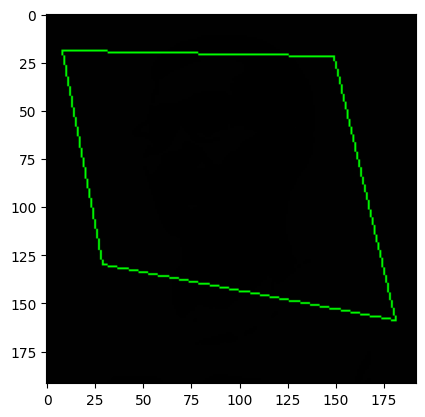

In [8]:
img = cv2.imread('vis_outputs/ground_truth_0.png')

plt.imshow(img)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(2,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
                                    
        self.layer2 = nn.Sequential(nn.Conv2d(64,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(64,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer5 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())        
        self.layer6 = nn.Sequential(nn.Conv2d(128,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer7 = nn.Sequential(nn.Conv2d(128,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(128,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.fc1 = nn.Linear(128*16*16,1024)
        self.fc2 = nn.Linear(1024,8)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.reshape(-1,128* 16* 16)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [4]:
model = Model().to(device)

# load saved weights to model
ckpt_pth = '/home/uig08207/DeepHomographyEstimation.pth'
ckpt = torch.load(ckpt_pth)
model.load_state_dict(ckpt['state_dict'])
optimizer = optim.SGD(model.parameters(),lr=0.005, momentum=0.9)
optimizer.load_state_dict(ckpt['optimizer'])
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/home/uig08207/DeepHomographyEstimation.pth'

In [2]:
'''
TRYING ON IR DATASET
'''
import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np

import argparse

import os





parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="Faces",help='MSCOCO,GoogleMap,GoogleEarth,DayNight')


parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=9,help='epoch_load_one')


parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=9,help='epoch_load_two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=9,help='epoch_load_three')

parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=20,help='num_iters')

parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')

parser.add_argument('--initial_type', action="store", dest="initial_type", default='vanilla',help='vanilla, simple_net, multi_net')

parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=40,help='load_epoch_simplenet')

parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[100,100,80],help='load_epoch_multinet')


input_parameters = parser.parse_args([])




gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)




def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    # prepare source and target four points
    matrix_list=[]
    for i in range(1):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)


def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.reduce_mean(tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2)))

    
    
    return average_conner
    





def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)


if input_parameters.feature_map_type=='regular':
    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one_regular/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two_regular/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three_regular/'

    level_one_input=ResNet_first_input(if_regular=True)
    level_one_template=ResNet_first_template(if_regular=True)
    level_two_input=ResNet_second_input(if_regular=True)
    level_two_template=ResNet_second_template(if_regular=True)
    level_three_input=ResNet_third_input(if_regular=True)
    level_three_template=ResNet_third_template(if_regular=True)

elif input_parameters.feature_map_type=='special':

    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three/'

    level_one_input=ResNet_first_input()
    level_one_template=ResNet_first_template()
    level_two_input=ResNet_second_input()
    level_two_template=ResNet_second_template()
    level_three_input=ResNet_third_input()
    level_three_template=ResNet_third_template()


level_one_input.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"input_full")

level_one_template.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"template_full")

level_two_input.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"input_full")

level_two_template.load_weights(load_path_two  + 'epoch_'+str(input_parameters.epoch_load_two)+"template_full")

level_three_input.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"input_full")

level_three_template.load_weights(load_path_three  + 'epoch_'+str(input_parameters.epoch_load_three)+"template_full")


if input_parameters.initial_type=='vanilla':
    initial_matrix=initial_motion_COCO()
    initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

if input_parameters.initial_type=='simple_net':
    save_path_regression='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    regression_network=Net_first()
    regression_network.load_weights(save_path_regression + 'epoch_'+str(input_parameters.load_epoch_simplenet))

if input_parameters.initial_type=='multi_net':
    save_path_one='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    save_path_two='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_2/'
    save_path_three='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_3/'
    regression_network_one=Net_first()
    regression_network_one.load_weights(save_path_one + 'epoch_'+str(input_parameters.load_epoch_multinet[0]))
    regression_network_two=Net_second()
    regression_network_two.load_weights(save_path_two + 'epoch_'+str(input_parameters.load_epoch_multinet[1]))
    regression_network_three=Net_third()
    regression_network_three.load_weights(save_path_three + 'epoch_'+str(input_parameters.load_epoch_multinet[2]))
    





LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)

LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)

LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)


LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)


if input_parameters.dataset_name=='MSCOCO':
    data_loader_caller=data_loader_MSCOCO('val')

if input_parameters.dataset_name=='GoogleMap':
    data_loader_caller=data_loader_GoogleMap('val')

if input_parameters.dataset_name=='GoogleEarth':
    data_loader_caller=data_loader_GoogleEarth('val')

if input_parameters.dataset_name=='DayNight':
    data_loader_caller=data_loader_DayNight('val')

if input_parameters.dataset_name=='Faces':
    data_loader_caller = data_loader_Faces('val')

1 Physical GPUs, 1 Logical GPUs


2023-06-27 05:50:56.738349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-06-27 05:50:57.069767: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xbbe1470


No of images loading:  1100


2023-06-27 05:50:58.219410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
input_img, u_list, v_list, template_img = data_loader_caller.data_read_batch(batch_size=1)

In [8]:
# estimate init homography
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_input = cv2.resize(input_img[0], (128, 128), interpolation=cv2.INTER_AREA)

test_template = template_img[0].copy()
test_input = cv2.cvtColor(test_input, cv2.COLOR_RGB2GRAY)

data = np.dstack((test_input, test_template))
data.shape

NameError: name 'input_img' is not defined

In [ ]:
data = np.expand_dims(data, axis=0)
print(data.shape)
data = torch.from_numpy(data)
data = data.to(device)
data = data.permute(0,3,1,2).float()
outputs = model(data)
print(outputs)

In [ ]:
outputs = outputs.cpu().detach().numpy()
print(outputs)
outputs = np.reshape(outputs, (4, 2))
print(outputs)

In [ ]:
patch_size = 128
top_point    = (32,32)
left_point   = (patch_size+32, 32)
bottom_point = (patch_size+32, patch_size+32)
right_point  = (32, patch_size+32)
four_points = np.asarray([top_point, left_point, bottom_point, right_point], dtype=np.float32)
homography_matrix = cv2.getPerspectiveTransform(four_points, np.add(four_points, outputs))

In [ ]:
total_error=0.0    

fk_loop=input_parameters.num_iters


for iters in range(10000000):
    input_img,u_list,v_list,template_img=data_loader_caller.data_read_batch(batch_size=1)
    if len(np.shape(input_img))<2:
        break

   

    if input_parameters.initial_type=='simple_net':
#         input_img_grey=tf.image.rgb_to_grayscale(input_img)
        input_img_grey=input_img
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
#         template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
        template_img_grey=template_img_new
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector=regression_network.call(network_input,training=False)
        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

    if input_parameters.initial_type=='multi_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_one=regression_network_one.call(network_input,training=False)
        matrix_one=construct_matrix_regression(1,homography_vector_one)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_one)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new) 
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_two=regression_network_two.call(network_input,training=False)
        matrix_two=construct_matrix_regression(1,homography_vector_one,homography_vector_two)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_two)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)  
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_three=regression_network_three.call(network_input,training=False)

        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector_three,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=np.dot(initial_matrix[0,:,:], np.linalg.inv(matrix_two[0,:,:]))
        initial_matrix=np.expand_dims(initial_matrix,axis=0)
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)



    # Create initial matrix from Keypoint detection and matching
#     input_img_8bit = cv2.normalize(input_img[0][:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
#     template_img_8bit = cv2.normalize(template_img[0][:,:,:3], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
#     input_img_8bit = cv2.cvtColor(input_img_8bit, cv2.COLOR_RGB2GRAY)

#     kp1, des1 = orb.detectAndCompute(input_img_8bit, None)
#     kp2, des2 = orb.detectAndCompute(template_img_8bit, None)

#     method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
#     matcher = cv2.DescriptorMatcher_create(method)
#     matches = matcher.match(des1, des2, None)
#     matches = sorted(matches, key=lambda x:x.distance)

#     keep = int(len(matches) * keep_ratio)
#     matches = matches[:keep]
#     pts1 = np.zeros((len(matches), 2), dtype='float')
#     pts2 = np.zeros((len(matches), 2), dtype='float')

#     for (i, m) in enumerate(matches):
#         pts1[i] = kp1[m.queryIdx].pt
#         pts2[i] = kp2[m.trainIdx].pt

#     H, mask = cv2.findHomography(pts1, pts2, method=cv2.RANSAC)
#     initial_matrix = construct_matrix(H, scale_factor=0.25, batch_size=1)
        
    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)


    if input_parameters.feature_map_type=='regular':
        input_feature_map_one=input_feature_one
        template_feature_map_one=template_feature_one

        input_feature_map_two=input_feature_two
        template_feature_map_two=template_feature_two

        input_feature_map_three=input_feature_three
        template_feature_map_three=template_feature_three

    elif input_parameters.feature_map_type=='special':
                
        input_feature_map_one=calculate_feature_map(input_feature_one)
        template_feature_map_one=calculate_feature_map(template_feature_one)

        input_feature_map_two=calculate_feature_map(input_feature_two)
        template_feature_map_two=calculate_feature_map(template_feature_two)

        input_feature_map_three=calculate_feature_map(input_feature_three)
        template_feature_map_three=calculate_feature_map(template_feature_three)
        
        
    updated_matrix=initial_matrix
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
        except:
            print ('s')

    predicted_matrix=updated_matrix
    print(predicted_matrix)

    cornner_error=average_cornner_error(1,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127)

    
    print (np.float(cornner_error))
    if iters>10:
        break

In [11]:
plt.imshow(input_img[0,:,:,:])
plt.show()
plt.imshow(input_feature_map_one[0,:,:,0])
plt.show()
plt.imshow(template_img[0,:,:,:])
plt.show()
plt.imshow(template_feature_map_one[0,:,:,0])
plt.show()